In [2]:
""" 
Prepare MIMIC dataset to run deep patient on the dataset
Desired columns: Patient ID, gender, list of ICD codes, mortality
TODO: add more response columns: e.g. number of days in ICU
"""

import collections
import pandas as pd
import sys
from datetime import datetime
import matplotlib.pyplot as plt

In [33]:
""" 
Global parameters
"""
target_diagnosis = "LUNG CA"

In [3]:
"""
Read in ADMISSIONS.csv and construct (1) patient ID to admission ID map, and \
    (2) admission ID to duration in hospital map (in seconds)
"""

pid_admids = {}
admid_duration = {}
admid_diagnosis = {}

admission_file = open("../mimiciii/ADMISSIONS.csv", 'r')
admission_file.readline()
for line in admission_file:
    tokens = line.strip().split(',')
    pid = int(tokens[1])
    admid = int(tokens[2])
    diagnosis = tokens[-3]
    if pid in pid_admids: pid_admids[pid].append(admid)
    else: pid_admids[pid] = [admid]

    admit_time = datetime.strptime(tokens[3], '%Y-%m-%d %H:%M:%S')
    discharge_time = datetime.strptime(tokens[4], '%Y-%m-%d %H:%M:%S')
    admid_duration[admid] = (discharge_time-admit_time).total_seconds()
    admid_diagnosis[admid] = diagnosis[1:-1]

admission_file.close()


In [4]:
""" 
Read in PATIENTS.csv and construct admission ID to gender map
"""
admid_gender = {}
patient_file = open("../mimiciii/PATIENTS.csv", 'r')
patient_file.readline()
for line in patient_file:
    tokens = line.strip().split(',')
    pid = int(tokens[1])
    gender = str(tokens[2])
    admids = pid_admids[pid]
    for admid in admids:
        admid_gender[admid] = gender[1]

patient_file.close()

In [5]:
""" 
Consruct admission ID to ICD codes mapping
"""

def convert_to_icd9(dxStr):
    """ 
    Source: https://github.com/mp2893/med2vec/blob/master/process_mimic.py
    I am not sure why ICD codes are converted in this way
    """
    if dxStr.startswith('E'):
        if len(dxStr) > 4: 
            return dxStr[:4] + '.' + dxStr[4:]
        else: 
            return dxStr
    else:
        if len(dxStr) > 3: return dxStr[:3] + '.' + dxStr[3:]
        else: return dxStr

admid_codes = {}
diagnosis_file = open("../mimiciii/diagnosisS_ICD.csv", 'r')
diagnosis_file.readline()
for line in diagnosis_file: # read ADMISSIONS.CSV in order
    tokens = line.strip().split(',')
    admid = int(tokens[2])
    dxStr = 'D_' + convert_to_icd9(tokens[4][1:-1]) # 1:-1 to remove quotes

    if admid in admid_codes: 
        admid_codes[admid].append(dxStr)
    else: 
        admid_codes[admid] = [dxStr]

diagnosis_file.close()


In [6]:
"""
Convert str codes to int codes
We use 0 to denote NA code in later analysis
"""

types = {}
for admid, codes in admid_codes.items():
    new_codes = []
    for code in codes:
        if code not in types:
            types[code] = len(types) + 1
        new_codes.append(types[code])
    admid_codes[admid] = new_codes


In [42]:
""" 
Construct a dataframe to store all information including
- patient ID (index key)
- gender
- expire (mortality)
- list of ICD codes
"""

admission_agg_df = pd.DataFrame(columns=['admid', 'gender','ICD codes','duration', 'diagnosis'])

for admid, codes in admid_codes.items():
    new_row = {"admid": admid, "gender": admid_gender[admid], "duration": admid_duration[admid], "ICD codes": codes, "diagnosis": admid_diagnosis[admid]}
    admission_agg_df = pd.concat([admission_agg_df, pd.DataFrame([new_row])], ignore_index=True)


admission_agg_df = admission_agg_df.set_index('admid')
admission_agg_df.to_csv("../mimiciii/ADMISSIONS_AGG.csv", index=True, header=True)

/home/wanxinli/.local/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [57]:
""" 
Choose lung cancer to be the response
Filter out rows which does not contain target diagnosis in diagnosis
"""
admission_diagnosis_agg_df = admission_agg_df.loc[admission_agg_df['diagnosis'].str.contains(target_diagnosis)]
admission_diagnosis_agg_df 

,gender,ICD codes,duration,diagnosis
admid,,,,
161473,M,"[104, 232, 308, 67, 28, 170, 48]",1910520.0,LUNG CA/SDA
147743,M,"[104, 46, 67, 62, 94, 10]",2028000.0,LUNG CANCER/SDA
190712,M,"[220, 114, 48, 251, 63, 115]",557400.0,LUNG CA/SDA
199523,M,"[147, 61]",1407000.0,LUNG CA/SDA
165018,M,"[35, 48]",496260.0,LUNG CANCER;HEMOPTYSIS
...,...,...,...,...
144869,F,"[10, 157, 379]",806820.0,LUNG CANCER/SDA
129743,M,"[220, 104, 48, 251, 63, 28, 170, 157]",556800.0,LEFT LUNG CANCER/SDA
107633,M,"[259, 61, 104, 10]",621000.0,LEFT UPPER LOBE LUNG CA/SDA


In [58]:
""" 
Plot code distribution for target diagnosis
"""

codes = []
for index, row in admission_diagnosis_agg_df.iterrows():
    codes.extend(row['ICD codes'])
        

In [59]:
print(len(codes))

1187


(array([36.,  0.,  0.,  1., 19.,  0.,  3.,  0., 24.,  9.,  1.,  0.,  0.,
         3.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  8.,  0.,  4., 22.,
        21.,  0.,  0.,  0., 33.,  0.,  0., 33., 13.,  0.,  0.,  0.,  7.,
         8.,  0.,  0., 19., 15., 26.,  0., 98.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  3., 12., 11., 39.,  0.,  0.,  0.,
        15.,  0.,  0.,  0.,  0., 13.,  0.,  3., 15.,  5.,  0.,  0., 19.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., 63.,  0.,  0.,  0.,  0.,  0., 26.,  0.,  5.,  6., 82.,  6.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5., 14.,  0.,  1.,  0.,
         0.,  9.,  0.,  1.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,
         8.,  0., 16.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0., 11., 42.,
         0.,  0.,  0., 13.,  0.,  0.,  0.,  0.,  0.,  7.,  0.,  4., 10.,
         0.,  0., 11.,  0., 13.,  0.,  2.,  0.,  0.

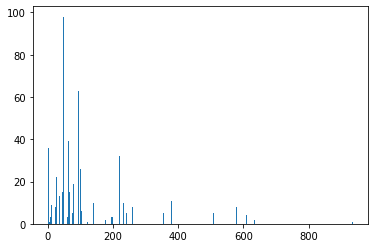

In [60]:

bin_width = 1
plt.hist(codes, bins=range(min(codes), max(codes) + bin_width, bin_width))


In [61]:
code_dict = dict(collections.Counter(codes))

# sort
code_dict = dict(sorted(code_dict.items(), key=lambda item: item[1], reverse=True))
num_top_codes = 50
target_codes = list(code_dict.keys())[:num_top_codes]
print(target_codes)

[48, 104, 94, 274, 157, 63, 2, 35, 32, 220, 251, 46, 100, 10, 27, 28, 44, 6, 79, 283, 147, 67, 45, 75, 115, 305, 36, 161, 175, 72, 61, 62, 259, 156, 379, 173, 232, 170, 140, 11, 120, 641, 145, 41, 24, 260, 578, 308, 285, 167]


In [62]:
""" 
Filter out code in admission_diagnosis_agg_df  
"""
for index, row in admission_diagnosis_agg_df.iterrows():
    admission_diagnosis_agg_df.at[index, 'ICD codes'] = [code for code in row['ICD codes'] if code in target_codes]


In [81]:
""" 
Filter out row with no ICD codes
"""
admission_diagnosis_agg_df = admission_diagnosis_agg_df[admission_diagnosis_agg_df['ICD codes'].map(len) > 0]


In [65]:
"""
Save dataframe
"""
admission_diagnosis_agg_df.to_csv("../../outputs/mimic/admission_diagnosis_agg.csv", header=True, index=True)


In [82]:
""" 
Calculates the number of males vs females in admission_diagnosis_agg_df 
"""
genders = list(admission_diagnosis_agg_df['gender'])
print("male number:", genders.count('M'))
print("female number:", genders.count('F'))

male number: 142
female number: 95
